In [104]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import datetime


pd.set_option('display.max_rows', None)

In [295]:
fig_path = f'plots/analyse_weekdays/berlin-biberach_E_2_2_11.11-25.11.png'
title = f'Price development over week: 11.11 - 25.11, adult, 55% discount, second class'
start_day = '11_11_2022'
route='berlin-biberach'
age='E'
discount='2'
tariffClass='2'
total_days = 14

In [296]:
def read_data(path):
    headers = ['price', 'ticket type', 'age', 'discount', 'date', 'departure', 'destination', 'duration', 'start time', 'arrival time', 'changes', 'tariffClass']
    return pd.read_csv(path, skiprows=[0], header=None, names=headers)

In [297]:
def clean_data(df_raw):
    df_clean = df_raw.drop_duplicates()

    df_clean.drop(df_clean[df_clean['ticket type'] == 'Normalpreis'].index, inplace = True)

    df_clean['price'] = df_clean['price'].str.replace(',','.')
    df_clean['price'] = df_clean['price'].astype(float)

    df_clean['date'] = df_clean['date'].str.slice(start=4)


    df_clean['datetime dep'] = df_clean['start time'] +'-'+ df_clean['date']
    df_clean['datetime arr'] = df_clean['arrival time'] +'-'+ df_clean['date']
    df_clean['datetime dep'] = pd.to_datetime(df_clean['datetime dep'], format="%H:%M-%d.%m.%Y")
    df_clean['datetime arr'] = pd.to_datetime(df_clean['datetime arr'], format="%H:%M-%d.%m.%Y")

    df_clean['sub [min]'] = (df_clean['datetime arr'] - df_clean['datetime dep']).astype('timedelta64[m]')

    df_clean = df_clean.drop('date', axis=1)
    df_clean = df_clean.drop('duration', axis=1)
    df_clean = df_clean.drop('start time', axis=1)
    df_clean = df_clean.drop('arrival time', axis=1)

    df_clean['departure'] = df_clean['departure'].apply(lambda x: 'Berlin' if x == 'Berlin+Hbf' else x)
    df_clean['destination'] = df_clean['destination'].apply(lambda x: 'Biberach' if x == 'Biberach%28Ri%C3%9F%29' else x)
    df_clean['destination'] = df_clean['destination'].apply(lambda x: 'Memmingen' if x == 'Bahnhof+ZOB%252C+Memmingen' else x)

    df_clean['time'] = pd.to_datetime(df_clean['datetime dep']).dt.strftime('%H:%M')
    return df_clean

In [298]:
def get_df_single_day(path):
    df = read_data(path)
    df = clean_data(df)
    return df

In [299]:
def merge_multiple_tables():
    day = datetime.datetime.strptime(start_day, '%d_%m_%Y').date()
    day_string = day.strftime('%d_%m_%Y')
    
    path=f'data/{route}/data_{age}_{discount}_{tariffClass}/{day_string}_{age}_{discount}.csv'
    merge_table = pd.DataFrame()
    for i in range(1, total_days):
        
        table = get_df_single_day(path)
        merge_table = pd.concat([merge_table, table], ignore_index=True)
        
        day = datetime.datetime.now() + datetime.timedelta(i)
        day_string = day.strftime('%d_%m_%Y')
        path=f'data/{route}/data_{age}_{discount}_{tariffClass}/{day_string}_{age}_{discount}.csv'
    return merge_table

In [300]:
df = merge_multiple_tables()


In [301]:
df = df.loc[df['ticket type'] == 'Flexpreis']


In [302]:
df['weekday'] = df['datetime dep'].dt.day_name()

In [308]:
df = df.sort_values(by=['time'])

min_price = df.loc[df['price'].idxmin()]
min_price


price                         86.15
ticket type               Flexpreis
age                               E
discount                          2
departure                    Berlin
destination                Biberach
changes                           1
tariffClass                       2
datetime dep    2022-11-19 21:28:00
datetime arr    2022-11-19 07:15:00
sub [min]                    -853.0
time                          21:28
weekday                    Saturday
Name: 391, dtype: object

/tmp/ipykernel_94393/1782217966.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(),rotation = 40)


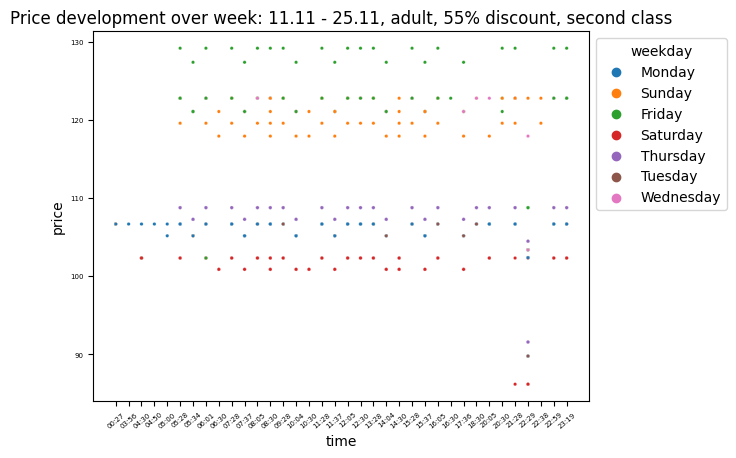

In [304]:
plt = sb.scatterplot(data=df, x='time', y='price', hue='weekday', s=6)
plt.set_xticklabels(plt.get_xticklabels(),rotation = 40)
plt.tick_params(labelsize=5)

plt.set(title=title)
sb.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))

fig = plt.get_figure()
fig.savefig(fig_path, dpi=200, bbox_inches='tight')